# Train YOLOv8 on football players detection

In this notebook, we train [YOLOv8](https://github.com/ultralytics/ultralytics) on the [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc) from Roboflow.

The dataset contains 255 images of football games. The players, referees, goalkeeper and ball are labeled.


Setup environment

In [1]:
!pip install roboflow

In [2]:
!pip install ultralytics

In [3]:
from ultralytics import YOLO
from pathlib import Path
from roboflow import Roboflow
import cv2
import numpy as np
import matplotlib.pyplot as plt

Download Dataset

In [4]:
Path("datasets").mkdir(exist_ok=True)
%cd datasets
rf = Roboflow(api_key="UxApJs5oZUkmngdc3qdV")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
dataset = project.version(4).download("yolov8")
%cd ..

In [5]:
path_dataset = Path("datasets/football-players-detection-4")
path_yaml = path_dataset/ "data.yaml"

In [6]:
len_train = len(list((path_dataset/ "train/images").iterdir()))
len_val = len(list((path_dataset/ "valid/images").iterdir()))
len_test = len(list((path_dataset/ "test/images").iterdir()))
print(f"Number of examples: train-{len_train}, val-{len_val}, test-{len_test}")

Number of examples: train-204, val-38, test-13


## Train YOLOv8 

For the training we opted for yolov8l and image size 640

In [7]:
model = YOLO("yolov8m.pt")

In [8]:
model.train(data=str(path_yaml), epochs=300, imgsz=640, device=0, batch=16)

Ultralytics YOLOv8.0.26 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=datasets/football-players-detection-4/data.yaml, epochs=300, patience=50, batch=16, imgsz=640, save=True, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=F

In [20]:
model.val()

Ultralytics YOLOv8.0.26 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
val: Scanning /content/datasets/football-players-detection-4/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]
                   all         38        905      0.945      0.755      0.832      0.585
                  ball         38         35          1      0.206      0.427      0.164
            goalkeeper         38         27      0.888      0.963      0.972      0.742
                player         38        754      0.953      0.964      0.986      0.796
               referee         38         89      0.938      0.888      0.942      0.637
Speed: 0.1ms pre-process, 16.6ms inference, 0.0ms loss, 1.4ms post-process per image


## Display prediction on test images

In [9]:
colors = {
    "ball": (0,200,200),
    "player": (255,0,0),
    "goalkeeper":(255,0,255),
    "referee": (0,0,255),
}

ind_to_cls = {
    0: "ball",
    1 : "goalkeeper",
    2 : "player",
    3 : "referee"
}

In [10]:
path_test_images = path_dataset/ "test/images"
test_image_paths = list(path_test_images.iterdir())
num_images = len(test_image_paths)

In [11]:
image_idx = np.random.randint(0, num_images)
image = cv2.imread(str(test_image_paths[image_idx]))

In [12]:
prediction = model(image)

Ultralytics YOLOv8.0.26 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs

0: 384x640 1 goalkeeper, 18 players, 3 referees, 18.3ms
Speed: 0.3ms pre-process, 18.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


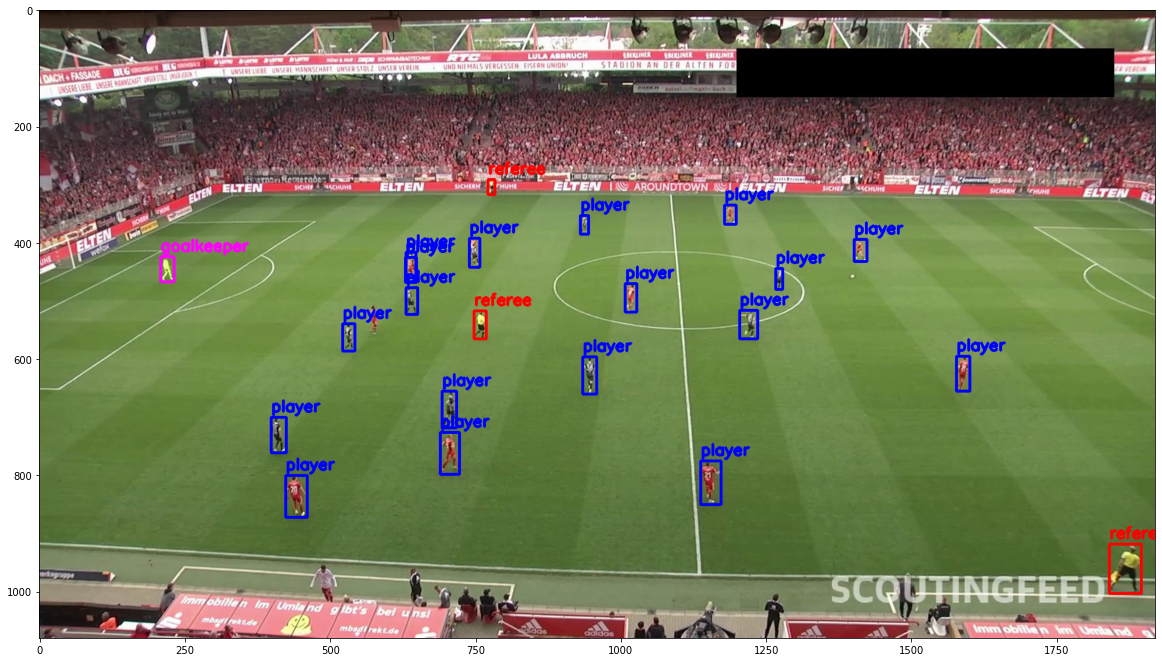

In [18]:
plt.figure(figsize=(20, 20))
for pred in prediction[0]:
    bbox = pred.boxes.xyxy.int().tolist()[0]
    cls_ind = pred.boxes.cls.int().item()
    cls = ind_to_cls[cls_ind]
    cv2.rectangle(img=image, pt1=tuple(bbox[:2]), pt2=tuple(bbox[2:]), color=colors[cls], thickness=3)
    cv2.putText(image, cls, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, colors[cls], 3)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.grid(False)
plt.show()